# Analysis of Auto-played games of Pokemon TCG Pocket

To collect the data, I turned on the "Auto" feature and let the AI run my games for me. I put my phone on my desk while it ran, then recorded the post-game statistics. 

- Every game *should* have the same probability of winning.
- The order in the data is the order of the games, so any streaks can be safely calculated based on the row order.


The deck is a relatively poorly made dark deck, and the opponent was Expert Mewtwo and Gardevoir.


In [1]:
suppressPackageStartupMessages({
    library(tidyverse)
    library(ggrepel)
    library(tseries)
    theme_set(theme_bw())
})

tcg <- read_csv("PTCGP.csv", show_col_types = FALSE) |>
    mutate(
        Result = if_else(P1 > P2, "Win", "Lose"),
        Order = if_else(Order == 1, "First", "Second")
    )
head(tcg)

dim(tcg)


Order,Turns,P1,P2,Damage,Result
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Second,11,2,3,230,Lose
First,14,1,3,80,Lose
Second,10,3,0,260,Win
First,15,3,2,270,Win
Second,11,0,3,110,Lose
Second,9,1,3,170,Lose


[1] 182   6

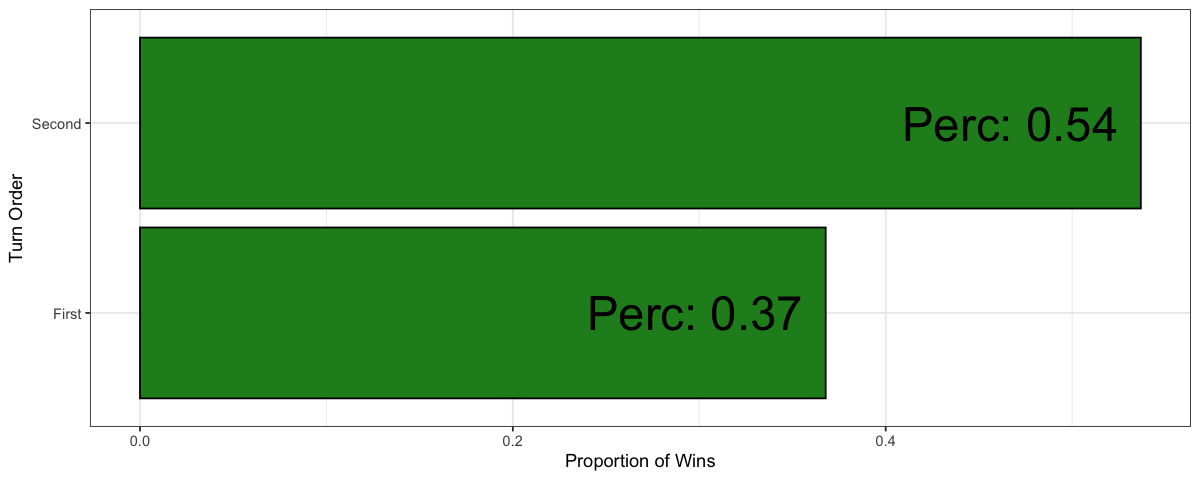

In [2]:
options(repr.plot.width = 10, repr.plot.height = 4)

win_by_order <- tcg |>
    group_by(Order) |>
    summarise(
        Win_Percentage = mean(Result == "Win"),
        Games = n(),
        Wins = sum(Result == "Win")
    )

ggplot(win_by_order) +
    aes(x = factor(Order), y = Win_Percentage) +
    geom_col(colour = 1, fill = "forestgreen") +
    labs(
        fill = NULL,
        x = "Turn Order",
        y = "Proportion of Wins"
    ) +
    geom_text(
        aes(label = str_c("Perc: ", round(Win_Percentage, 2))),
        nudge_y = -0.07, size = 10
    ) +
    coord_flip() 


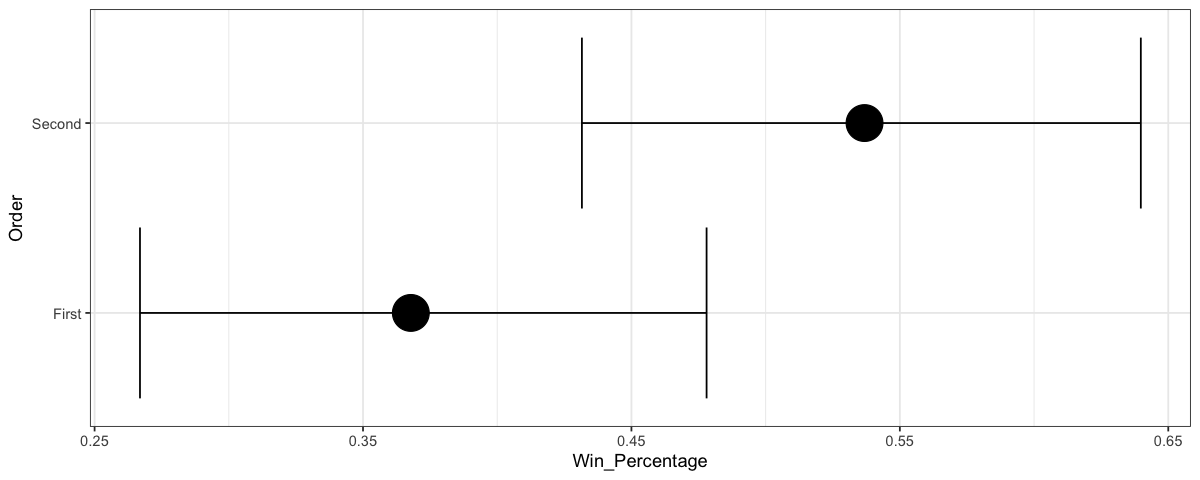

In [ ]:
lo <- function(x, n) as.numeric(binom.test(x = x, n = n)$conf.int)[1]
hi <- function(x, n) as.numeric(binom.test(x = x, n = n)$conf.int)[2]

win_by_order |>
    rowwise() |>
    mutate(
        lo = lo(Wins, Games),
        hi = hi(Wins, Games)
    ) |>
    ggplot() +
    aes(x = Order, y = Win_Percentage, ymin = lo, ymax = hi) +
    geom_point(size = 10) +
    geom_errorbar() +
    coord_flip()


In [ ]:
binom.test(x = win_by_order$Wins, n = win_by_order$Games, alternative = "less")



	Exact binomial test

data:  win_by_order$Wins
number of successes = 32, number of trials = 83, p-value = 0.02376
alternative hypothesis: true probability of success is less than 0.5
95 percent confidence interval:
 0.0000000 0.4814957
sample estimates:
probability of success 
             0.3855422 


**Conclusion**: This deck is statistically significantly more likely to lose when it goes first!

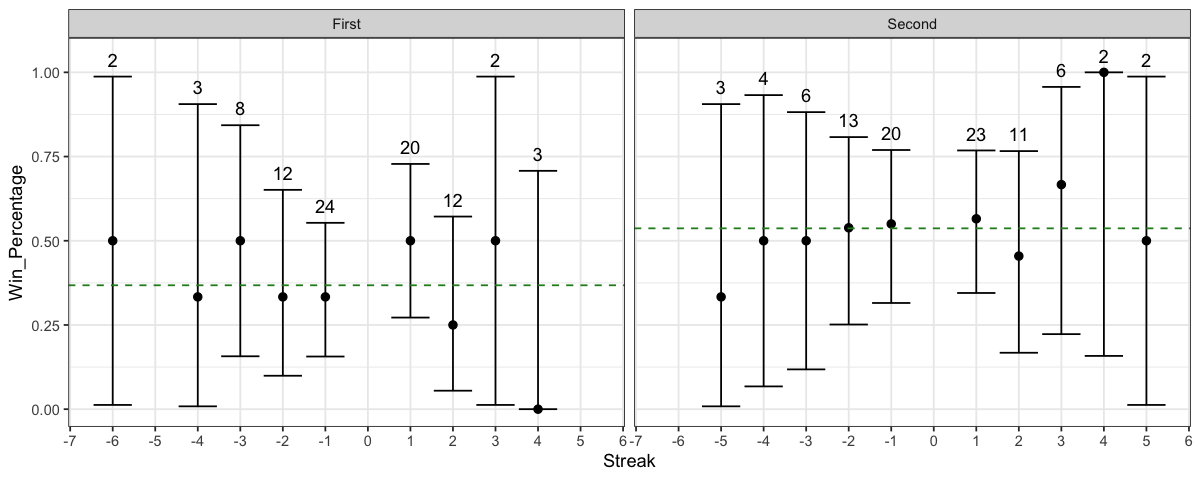

In [5]:
run_lengths <- rle(tcg$Result)$lengths
run_values <- rle(tcg$Result)$values

streak <- sapply(seq_along(run_lengths), function(x) {
    1:run_lengths[x] * ifelse(run_values[x] == "Win", 1, -1)
}) |> unlist()

tcg$Streak <- c(NA, streak[1:(length(streak) - 1)])
lo <- function(p, n) as.numeric(binom.test(x = round(p * n), n = n)$conf.int)[1]
hi <- function(p, n) as.numeric(binom.test(x = round(p * n), n = n)$conf.int)[2]

tcg |>
    group_by(Streak, Order) |>
    summarise(
        Win_Percentage = mean(Result == "Win"), Games =  n(),
        .groups = "drop"
    ) |>
    rowwise()|> 
    mutate(
        lo = lo(Win_Percentage, Games),
        hi = hi(Win_Percentage, Games)
    ) |>
    filter(Games > 1) |>
    ggplot() +
    aes(x = Streak, y = Win_Percentage) +
    geom_point(aes(colour = Streak > 0), na.rm = TRUE, colour = 1, size = 2) +
    geom_errorbar(aes(ymin = lo, ymax = hi), na.rm = TRUE) +
    geom_text(aes(y = hi, label = Games), na.rm = TRUE, nudge_y = 0.05) +
    theme(legend.position = "none") +
    scale_colour_manual(values = c("firebrick", "forestgreen")) +
    scale_x_continuous(breaks = -10:10, minor_breaks = NULL) +
    facet_wrap(~ Order) +
    geom_hline(
        aes(yintercept = Win_Percentage), data = win_by_order,
        colour = "forestgreen", linetype = "dashed"
    )


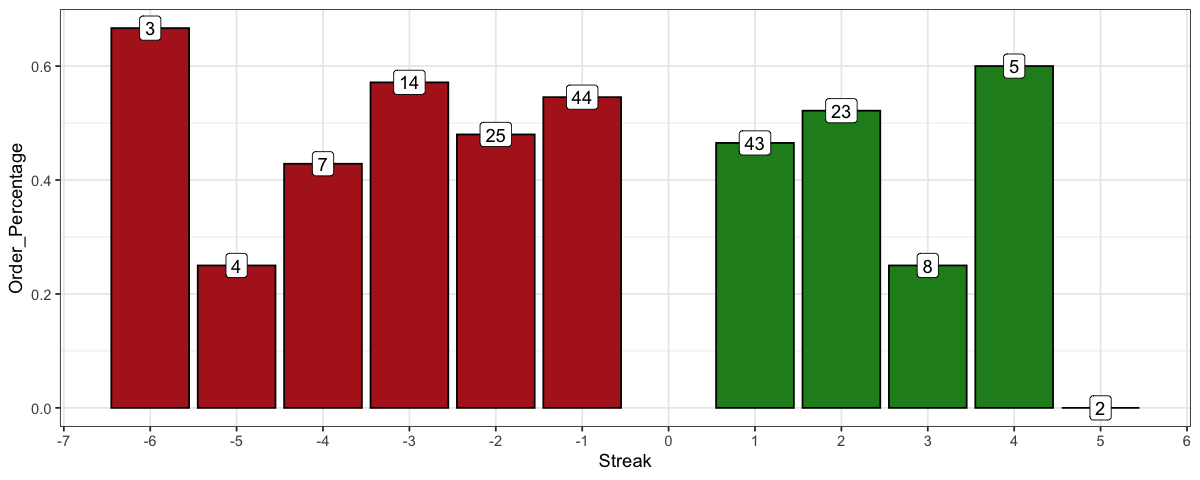

In [6]:

tcg |>
    group_by(Streak) |>
    summarise(
        Order_Percentage = mean(Order == "First"), Games =  n(),
        .groups = "drop"
    ) |>
    filter(Games > 1) |>
    ggplot() +
    aes(x = Streak, y = Order_Percentage) +
    geom_col(aes(fill = Streak > 0), na.rm = TRUE, colour = 1) +
    geom_label(aes(label = Games), na.rm = TRUE) +
    theme(legend.position = "none") +
    scale_fill_manual(values = c("firebrick", "forestgreen")) +
    scale_x_continuous(breaks = -10:10, minor_breaks = NULL)


**Claim**: If you're on a losing streak, the game tends to give you more heads when you flip coins.

In [ ]:
tseries::runs.test(factor(tcg$Order))



	Runs Test

data:  factor(tcg$Order)
Standard Normal = -0.42066, p-value = 0.674
alternative hypothesis: two.sided


**Conclusion**: There does *not* seem to be a deviation from randomness in the heads and tails for choosing the order.

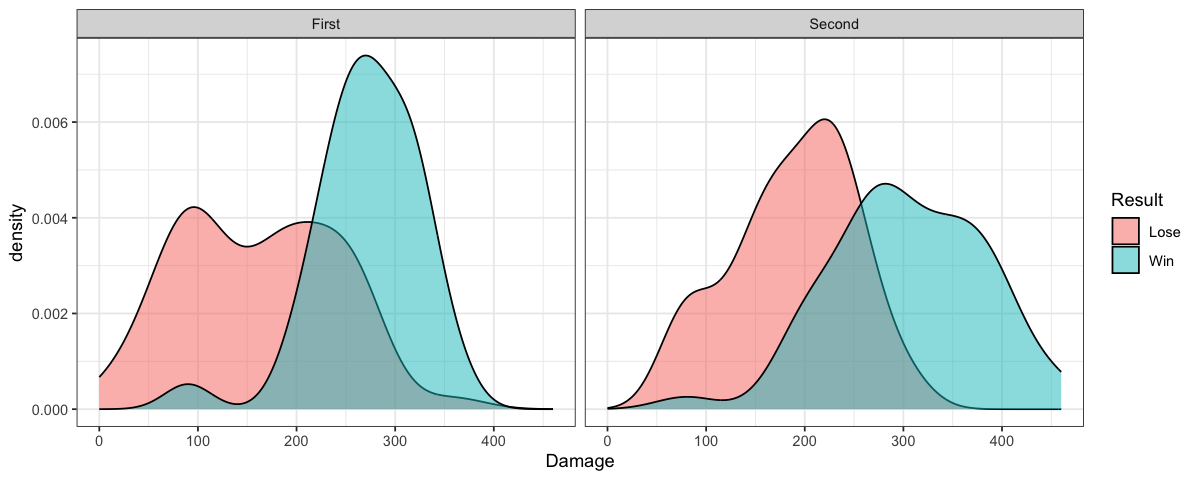

In [ ]:
tcg |>
    ggplot() +
    aes(x = Damage, fill = Result) +
    geom_density(colour = 1, alpha = 0.5) +
    facet_wrap(~Order)


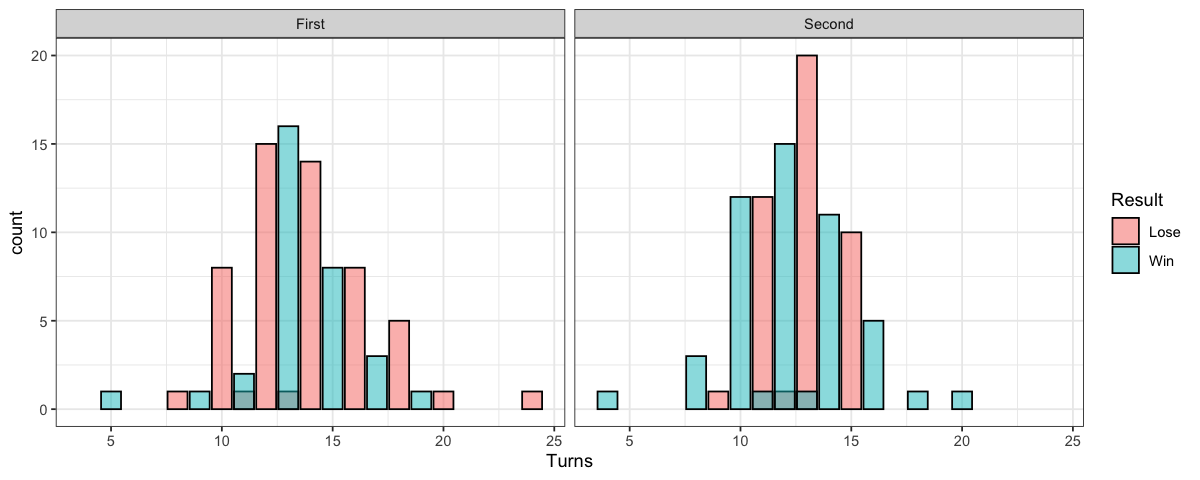

In [ ]:
tcg |>
    ggplot() +
    aes(x = Turns, fill = Result) +
    geom_bar(position = "identity", alpha = 0.5, colour = 1) +
    facet_wrap(~ Order)
